In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
data_ = pd.read_csv('/content/CC GENERAL.csv')
print(data_.shape)
data_.describe()

(8950, 18)


BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

#Dealing with Missing Values

In [3]:
def missings_(data):
    miss      = data.isnull().sum()
    miss_pct  = 100 * data.isnull().sum()/len(data)
    
    miss_pct      = pd.concat([miss,miss_pct], axis=1)
    missings_cols = miss_pct.rename(columns = {0:'Missings', 1: 'Missing pct'})
    missings_cols = missings_cols[missings_cols.iloc[:,1]!=0].sort_values('Missing pct', ascending = False).round(1)
    
    return missings_cols 
    
missings = missings_(data_)
missings

Missings  Missing pct
MINIMUM_PAYMENTS       313          3.5
CREDIT_LIMIT             1          0.0

#Violin plots for checking outliers

<ipython-input-4-93617c12fc75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sub['BALANCE_FREQ'] = round(data_['BALANCE_FREQUENCY'],2)


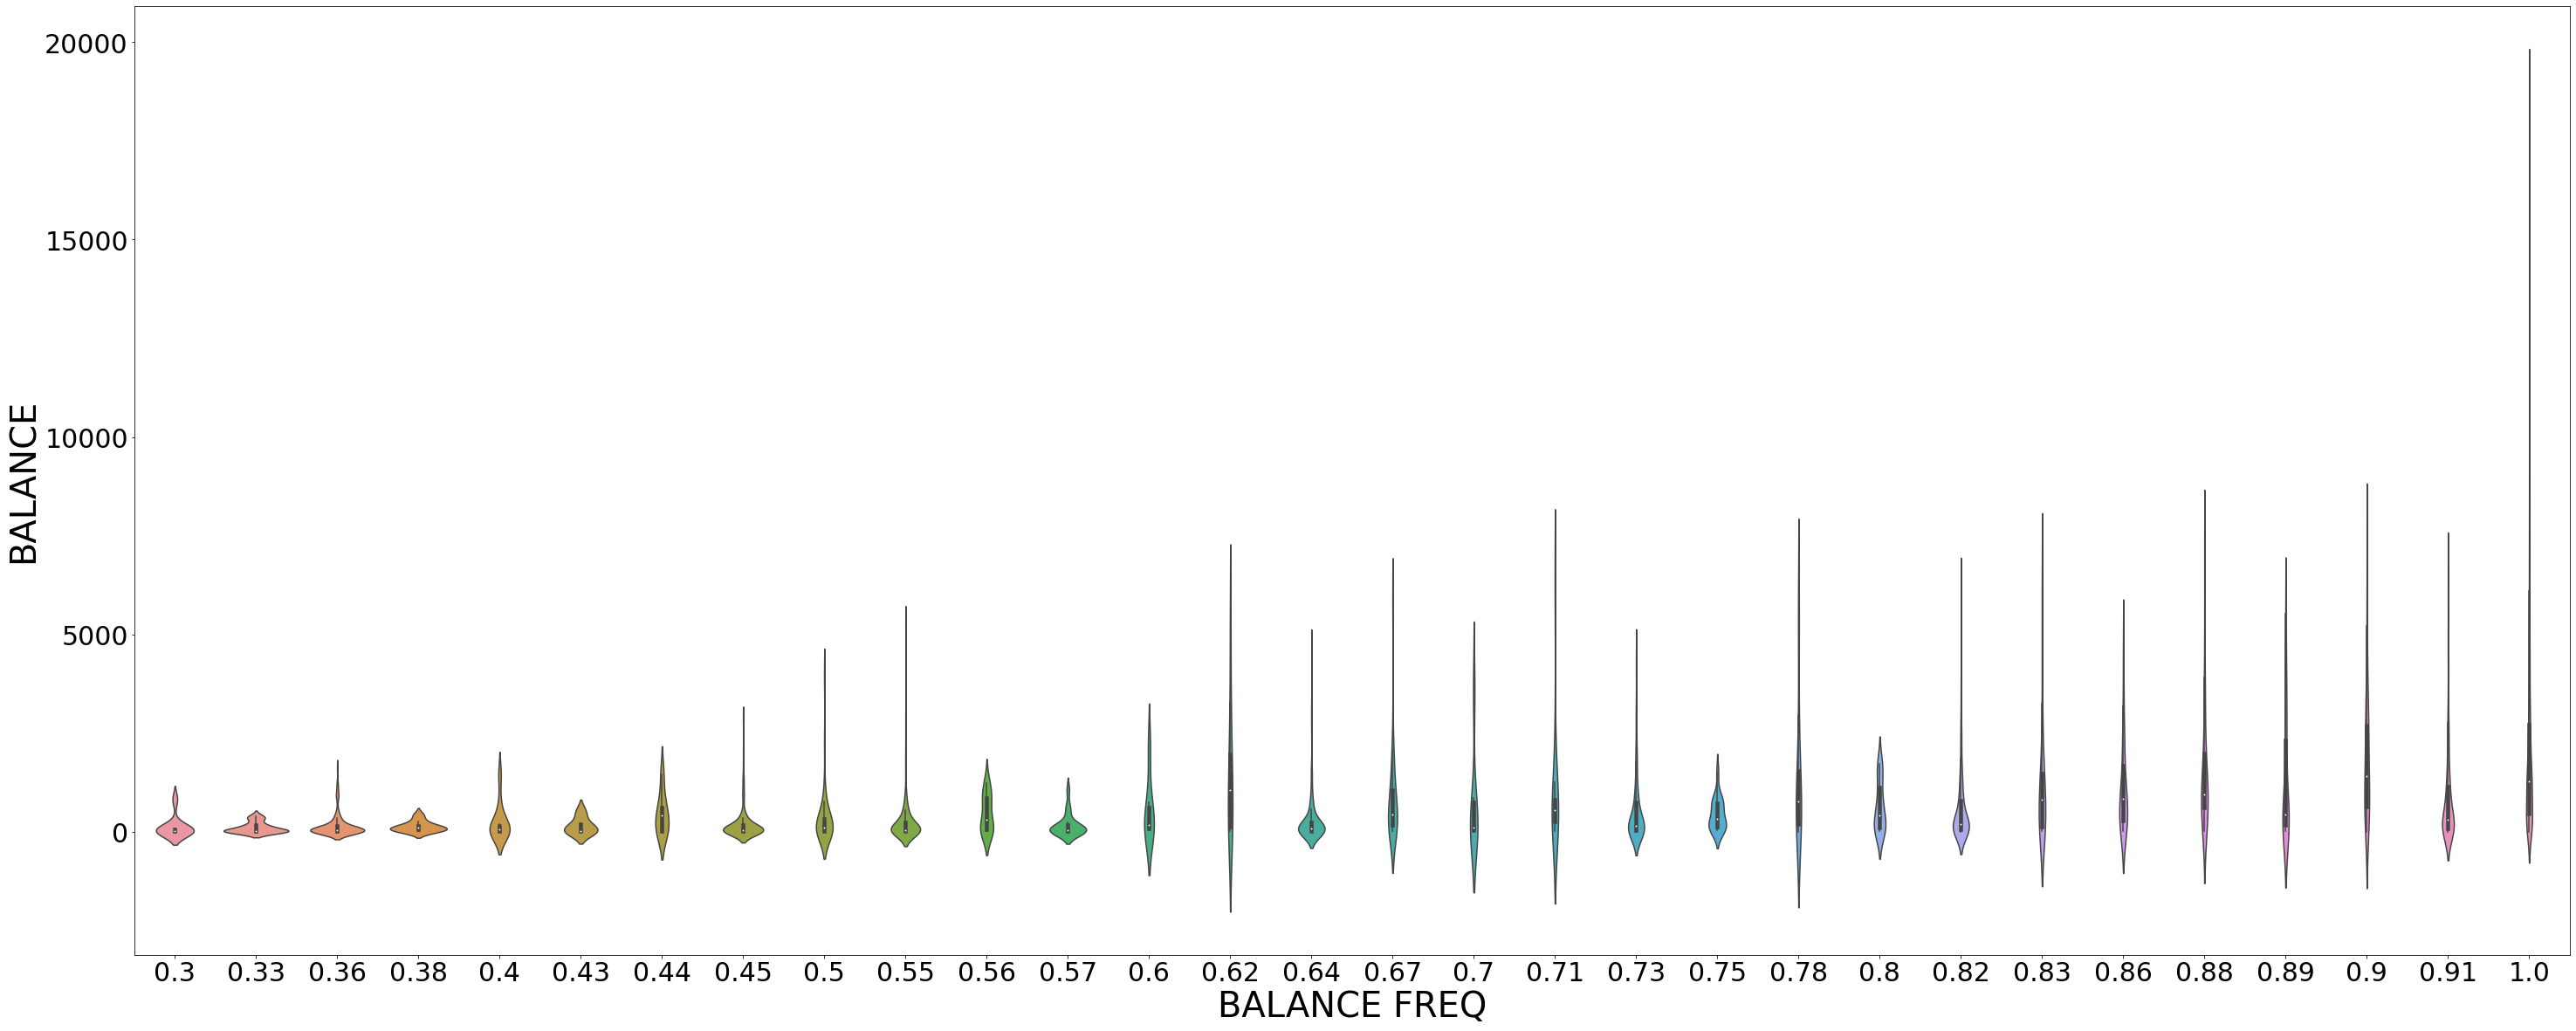

In [4]:
fig = plt.figure(figsize = (50,20))
data_sub = data_[(data_['BALANCE_FREQUENCY']>=0.3)]
data_sub['BALANCE_FREQ'] = round(data_['BALANCE_FREQUENCY'],2)

sns.violinplot(y='BALANCE',x='BALANCE_FREQ',data=data_sub)
plt.xlabel('BALANCE FREQ',fontsize=40)
plt.ylabel('BALANCE',fontsize=40)
plt.tick_params(labelsize=30)

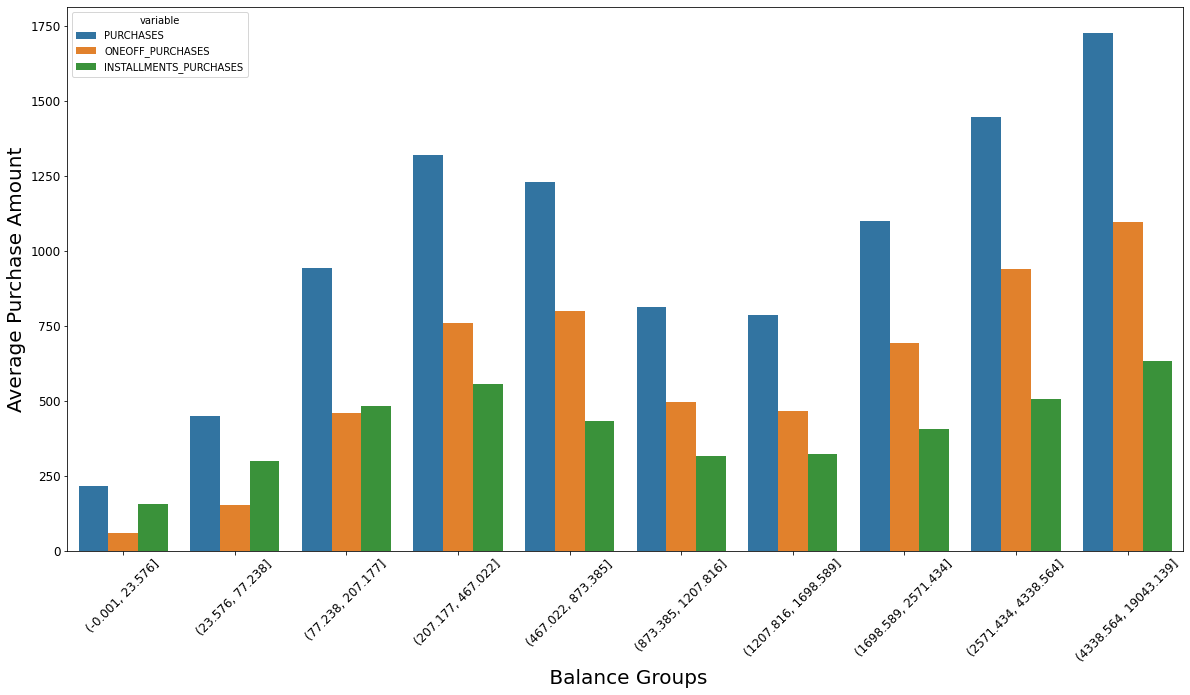

In [8]:
data_['Balance_decile'] = pd.qcut(data_['BALANCE'], q=10)
data_grp   = data_.groupby('Balance_decile', as_index=False).mean()
data_grp   = data_grp[['Balance_decile', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES']]
data_grp_t = pd.melt(data_grp, id_vars = 'Balance_decile')

fig = plt.figure(figsize=(20,10))
sns.barplot(x= "Balance_decile" , y = "value", hue = 'variable', data =data_grp_t)
plt.ylabel("Average Purchase Amount", fontsize=20)
plt.xlabel(" Balance Groups", fontsize =20)
plt.tick_params(labelsize=12)
plt.xticks(rotation=45)
plt.show()

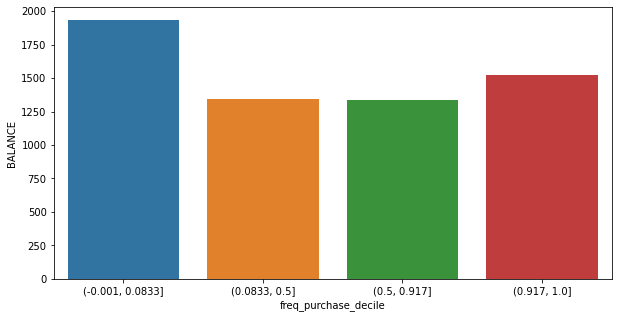

In [10]:
data_['freq_purchase_decile'] = pd.qcut(data_['PURCHASES_FREQUENCY'], q=4)

data_bal   = data_.groupby('freq_purchase_decile', as_index=False).mean()
fig = plt.figure(figsize=(10,5))
sns.barplot(x= "freq_purchase_decile" , y = "BALANCE", data =data_bal)
plt.show()

#Dealing with Outliers - beans

In [11]:
data_n  = data_.copy()

cols = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES','CASH_ADVANCE',
         'CREDIT_LIMIT', 'PAYMENTS']
for c in cols:
    bins = c+'_bin'
    max_ = max(data_n[c])
    data_n[bins] = pd.cut(data_n[c], bins=[0,500,1000,3000,5000,10000,15000,max_],labels = [1,2,3,4,5,6,7], include_lowest= True)
cols = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY',
         'CASH_ADVANCE_FREQUENCY']
for c in cols:
    bins = c+'_bin'
    max_ = max(data_[c])
    data_n[bins] = pd.cut(data_n[c], bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,max_],labels = [1,2,3,4,5,6,7,8,9,10], include_lowest= True)

cols = ['CASH_ADVANCE_TRX', 'PURCHASES_TRX']

for c in cols:
    bins = c+'_bin'
    max_ = max(data_[c])
    data_n[bins] = pd.cut(data_n[c], bins=[0,20,40,60,80,100,max_],labels = [1,2,3,4,5,6], include_lowest= True)
#Now, dropping some of the variables

data_model  = data_n.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'Balance_decile',
       'freq_purchase_decile', 'CC_utilisation', 'TENURE', 'PURCHASES_TRX_bin', 'CASH_ADVANCE_TRX_bin','CC_util_decile'], axis=1)

#Normalizing input values

In [12]:
stand_         = StandardScaler()
data_model_std = stand_.fit_transform(data_model)

#Clustering using Kmeans

Text(0.5, 1.0, 'Elbow Curve')

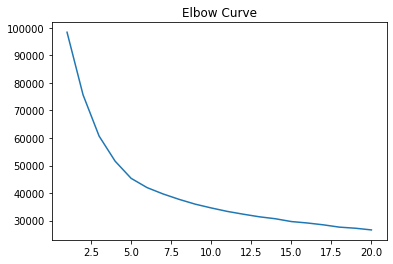

In [13]:
random.seed(234)
n_clusters=20
sse=[]
for i in range(1,n_clusters+1):
    kmean= KMeans(i)
    kmean.fit(data_model_std)
    sse.append([i, kmean.inertia_])
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1])
plt.title("Elbow Curve")

In [14]:
random.seed(234)
kmean= KMeans(8)
kmean.fit(data_model_std)
y_kmeans = kmean.predict(data_model_std)
data_model['Cluster']       = y_kmeans
data_model_std              = pd.DataFrame(data_model_std)
data_model_std['Cluster']   = y_kmeans

#Now, visualizing the clusters and analyze if these can be combined.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Text(0, 0.5, 'Cumulative Variance Explained')

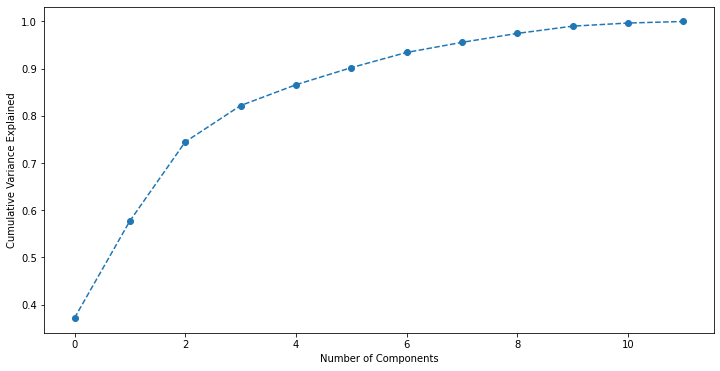

In [16]:
random.seed(32)
pca = PCA()
pca.fit(data_model_std)
fig = plt.figure(figsize =(12,6))
plt.plot(range(0,12),pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle = "--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")

In [18]:
data_model["Cluster"].replace({3: 1, 2: 0, 5:4}, inplace=True)
data_model_std["Cluster"].replace({3: 1, 2: 0, 5:4}, inplace=True)
clusters_   = data_model["Cluster"]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


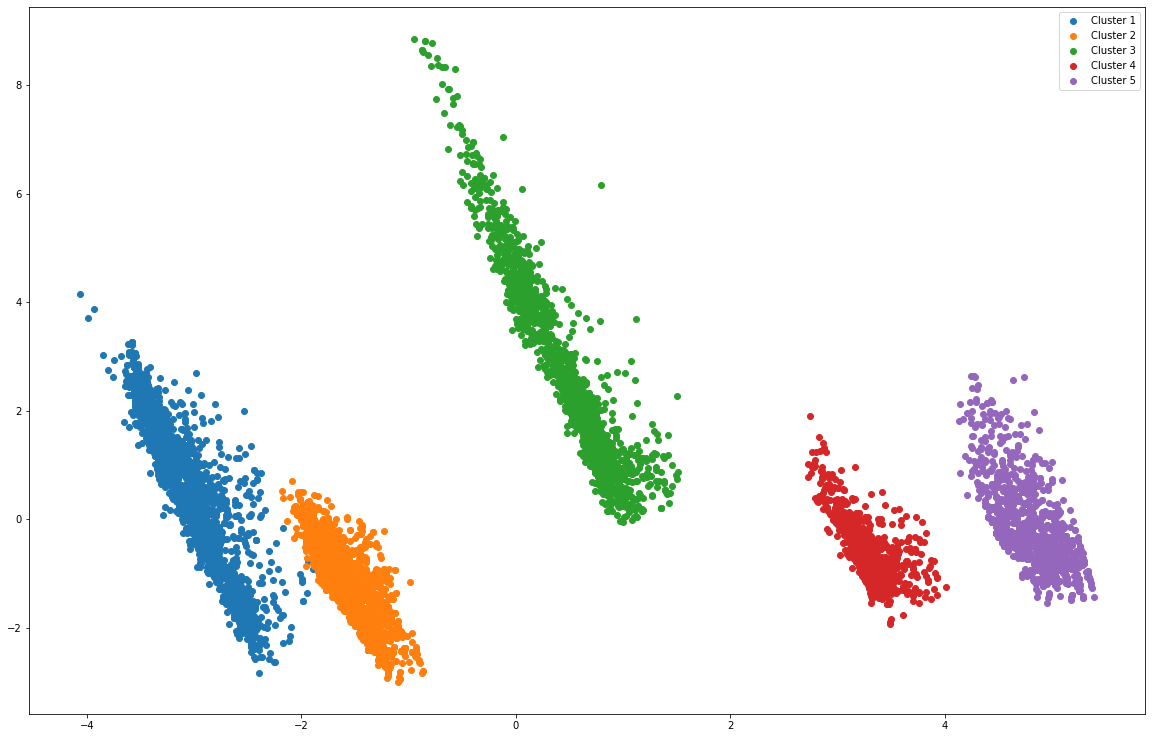

In [19]:
pca = PCA(n_components = 3)
pca.fit(data_model_std)

scores = pca.transform(data_model_std)

x,y = scores[:,0] , scores[:,1]
df_data = pd.DataFrame({'x': x, 'y':y, 'clusters':clusters_})
grouping_ = df_data.groupby('clusters')
fig, ax = plt.subplots(figsize=(20, 13))

names = {0: 'Cluster 1', 
         1: 'Cluster 2', 
         4: 'Cluster 3',
         6: 'Cluster 4',
         7: 'Cluster 5'}

for name, grp in grouping_:
    ax.plot(grp.x, grp.y, marker='o', label = names[name], linestyle='')
    ax.set_aspect('auto')

ax.legend()
plt.show()

In [20]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
x,y,z = scores[:,0] , scores[:,1], scores[:,2]

df_data = pd.DataFrame({'x': x, 'y':y, 'z':z, 'clusters':clusters_})

In [21]:
# Visualize cluster shapes in 3d.

cluster1=df_data.loc[df_data['clusters'] == 0]
cluster2=df_data.loc[df_data['clusters'] == 1]
cluster3=df_data.loc[df_data['clusters'] == 4]
cluster4=df_data.loc[df_data['clusters'] == 6]
cluster5=df_data.loc[df_data['clusters'] == 7]


scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.to_numpy()[:,0], y = cluster1.to_numpy()[:,1], z = cluster1.to_numpy()[:,2],
    marker = dict( size=2, color='green')
)
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.to_numpy()[:,0], y = cluster2.to_numpy()[:,1], z = cluster2.to_numpy()[:,2],
    marker = dict( size=2, color='blue')
)
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.to_numpy()[:,0], y = cluster3.to_numpy()[:,1], z = cluster3.to_numpy()[:,2],
    marker = dict( size=2, color='red')
)

scatter4 = dict(
    mode = "markers",
    name = "Cluster 4",
    type = "scatter3d",    
    x = cluster4.to_numpy()[:,0], y = cluster4.to_numpy()[:,1], z = cluster4.to_numpy()[:,2],
    marker = dict( size=2, color='orange')
)

scatter5 = dict(
    mode = "markers",
    name = "Cluster 5",
    type = "scatter3d",    
    x = cluster5.to_numpy()[:,0], y = cluster5.to_numpy()[:,1], z = cluster5.to_numpy()[:,2],
    marker = dict( size=2, color='yellow')
)


################## Clusters  ##############

cluster1 = dict(
    alphahull = 5,
    name = "Cluster 1",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.to_numpy()[:,0], y = cluster1.to_numpy()[:,1], z = cluster1.to_numpy()[:,2],
    color='green', showscale = True
)
cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.to_numpy()[:,0], y = cluster2.to_numpy()[:,1], z = cluster2.to_numpy()[:,2],
    color='blue', showscale = True
)
cluster3 = dict(
    alphahull = 5,
    name = "Cluster 3",
    opacity = .1,
    type = "mesh3d",    
    x = cluster3.to_numpy()[:,0], y = cluster3.to_numpy()[:,1], z = cluster3.to_numpy()[:,2],
    color='red', showscale = True
)

cluster4 = dict(
    alphahull = 5,
    name = "Cluster 4",
    opacity = .1,
    type = "mesh3d",    
    x = cluster4.to_numpy()[:,0], y = cluster4.to_numpy()[:,1], z = cluster4.to_numpy()[:,2],
    color='orange', showscale = True
)

cluster5 = dict(
    alphahull = 5,
    name = "Cluster 5",
    opacity = .1,
    type = "mesh3d",    
    x = cluster5.to_numpy()[:,0], y = cluster5.to_numpy()[:,1], z = cluster5.to_numpy()[:,2],
    color='yellow', showscale = True
)

layout = dict(
    title = '3D visulization of Clusters',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    )
)
fig = dict( data=[scatter1, scatter2, scatter3, scatter4, scatter5, cluster1, cluster2, cluster3, cluster4, cluster5], layout=layout )
# Use py.iplot() for IPython notebook
plotly.offline.iplot(fig, filename='mesh3d_sample')

#Profiling Clusters

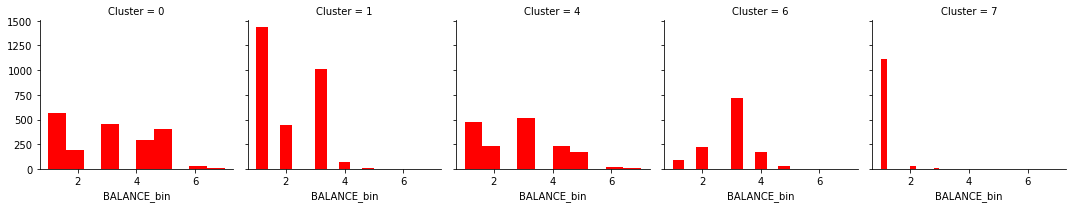

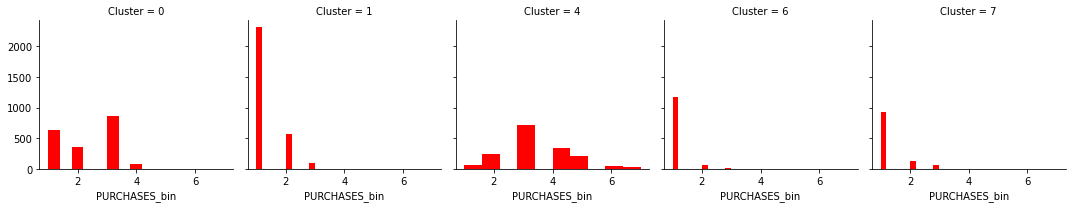

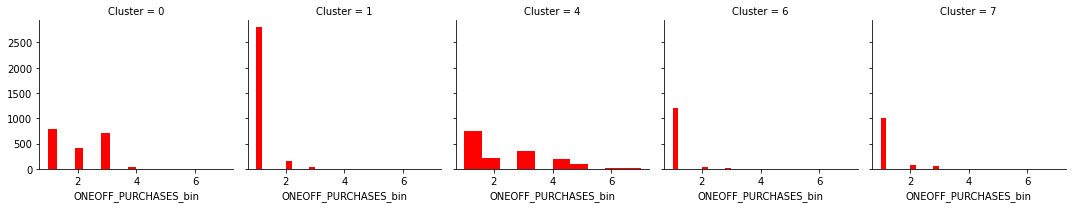

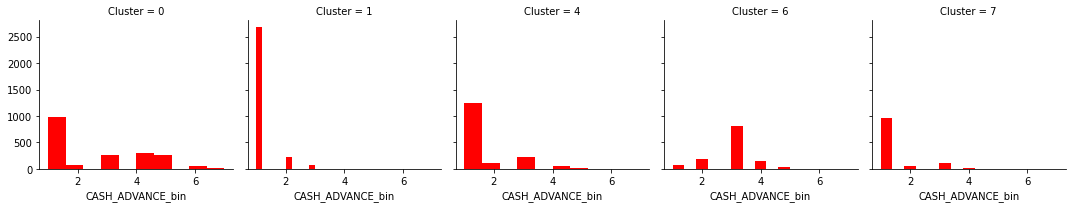

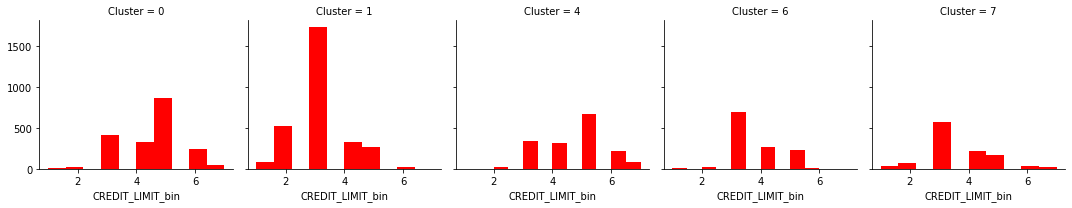

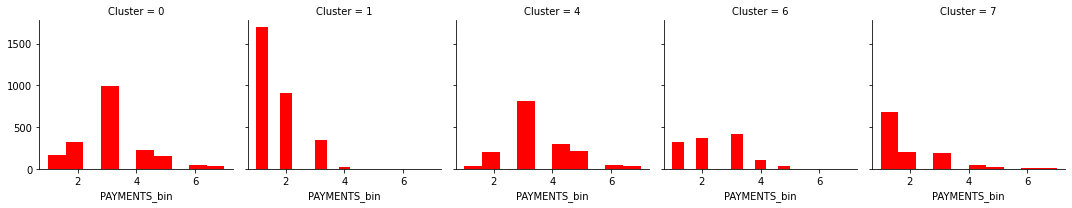

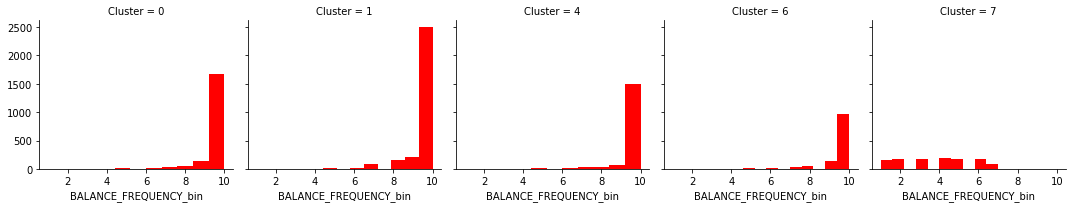

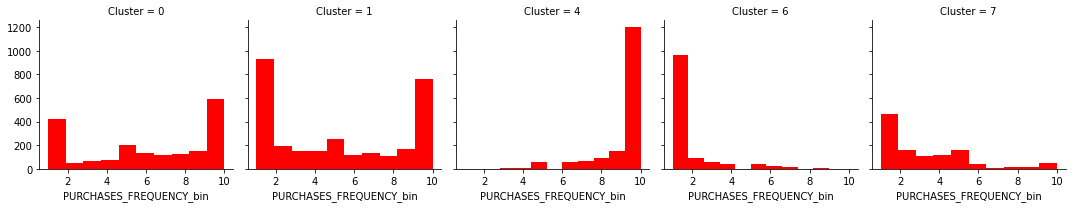

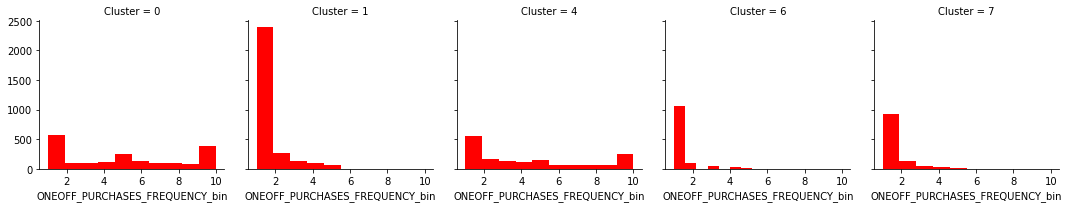

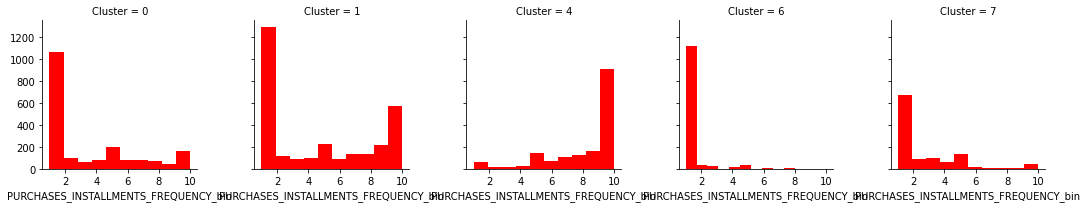

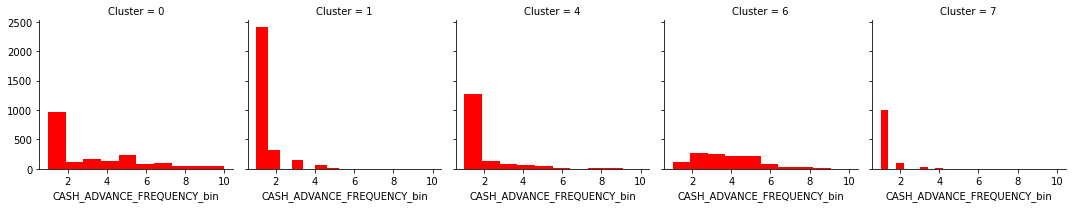

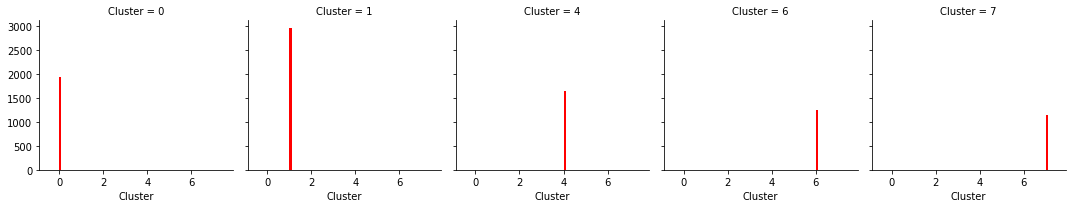

In [22]:
#fig  = plt.figure(figsize = (7200,30))
for c in data_model:
    g   = sns.FacetGrid(data_model, col='Cluster')
    g.map(plt.hist, c, color = "red")

Cluster 0: Who do not purchase but have a good credit limit. Also, miss payments

Cluster 1: Who have a good balance, make average purchases and do make payments

Cluster 4: Who buys frequently and have a high credit limit

Cluster 6: Who buys very small, keeps low balance but frequently pay dues

Cluster 7: Who only buys in installments

It’s quite interesting to study the Credit Card behavior of customers and take action on them. The Risk team can talk to the collections team to be cautious of Cluster 0 while the Marketing team can contact Cluster 1 & Cluster 4.

Even Cluster 7 could also be targeted with different Merchant offers on Electronics, Mobiles, Furniture or Travel